## Setup database connectivity

We'll reuse our module from the previous notebook (***`database_connectivity_setup.ipynb`***) to establish connectivity to the database

In [1]:
%run 'database_connectivity_setup.ipynb'

Your connection object is ***`conn`***:
1. Queries: You can run your queries using ***```psql.read_sql("""<YOUR SQL>""", conn)```***.
2. Create/Delete/Updates: You can run these statements using ***```psql.execute("""<YOUR SQL>""", conn)```***, followed by a ***```conn.commit()```*** command to ensure your transaction is committed. Otherwise your changes will be rolledback if you terminate your kernel.

If you created a new connection object (say to connect to a new cluster) as shown in the last section of `00_database_connectivity_setup.ipynb` notebook, use that connection object where needed.

#### Import the Necessary Python Packages

In [2]:
%matplotlib inline
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from PIL import Image

#### Canny Edge Detection Using PL/C

We will demonstrate how we can leverage existing native C and C++ application code within our MPP database (Greenplum or HAWQ). The sample application we consider here is an Edge detection application, a common pre-processing step for building out more complex image processing and computer vision applications. 

#####Problem set up:

We have an existing Canny's edge detection application developed using OpenCV, a popular library of computer vision functions that we wish to leverage to process many images in parallel in our MPP database using PL/C User Defined Functions. 

#####Compiling native C and C++ application code as a dynamic library
The code below illustrates the Canny edge detection internal functions edgeDetectionFromByteStream and getImgSizeFromByteStream and the corresponding Postgres interfaces. 

The first step would be to compile the application as a dynamic library (.so file). For PL/C, the application needs to be compiled using the correct Postgres headers, which might require the inclusion of the header files path. For example, on a CentOS system, the command illustrated below can be used to compile the Canny edge detection application.

```
g++ -shared -Wl,-soname,canny_plc -fPIC -I/usr/local/hawq-1.2.0.0/include/postgresql/server/ -I/usr/local/hawq-1.2.0.0/include/postgresql/internal -I/usr/local/hawq-1.2.0.0/include/ -o canny_plc.so -lopencv_core -lopencv_imgproc -lopencv_highgui CannyPLC.cpp
```

Once the shared object has been built, the next step is to install the shared object and the dependent libraries on all the Greenplum or HAWQ segment nodes. This is achieved via the gpscp command as illustrated in Figure 14.

```
gpscp -f hostfile canny_plc.so libopencv_core.so.2.4 libopencv_imgproc.so.2.4 libopencv_highgui.so.2.4 =:/usr/local/lib/ds
```

The inputs to the gpscp command are the hostfile parameter — a file containing the host names of segments nodes in Greenplum or HAWQ (in our case the segments are named hdw1 to hdw16), the filenames of the shared objects to copy and the path of the destination directory on the segment nodes (in our case /usr/local/lib/ds).

Now that our dynamic libraries have been distributed to all segment nodes, ensure that the environment variable LD_LIBRARY_PATH is updated to include the directory where we copied our files do and restart HAWQ. This can be achieved by adding the following to ~/.bashrc on all segment nodes

```
gpssh -f hostfile
echo “export LD_LIBRARY_PATH=\$LD_LIBRARY_PATH:/usr/local/lib/ds” >> ~/.bashrc
gpstop -r
```

```
/**
* CannyPLC.cpp
* Gautam Muralidhar,Srivatsan Ramanujam Oct 2014
* PL/C function for invoking Canny’s Edge Detection from OpenCV
**/
#include <iostream>
#include <string>
#include <vector>
#include "opencv2/opencv.hpp"
#include "opencv2/imgproc/imgproc.hpp"
#include <stdint.h>
using namespace std;

void Tokenize(
    const string& str,
    vector<string>& tokens,
    const string& delimiters = " ") {
    // Skip delimiters at beginning.
    string::size_type lastPos = str.find_first_not_of(delimiters, 0);
    // Find first "non-delimiter".
    string::size_type pos  = str.find_first_of(delimiters, lastPos);

    while (string::npos != pos || string::npos != lastPos)
    {
        // Found a token, add it to the vector.
        tokens.push_back(str.substr(lastPos, pos - lastPos));
        // Skip delimiters.  Note the "not_of"
        lastPos = str.find_first_not_of(delimiters, pos);
        // Find next "non-delimiter"
        pos = str.find_first_of(delimiters, lastPos);
    }
}

bool edgeDetectionFromByteStream(vector<int8_t> src, uint* result){
    cv::Mat srcImg, srcGray, dstImg, onesImg, edges;
    srcImg = cv::imdecode(src, CV_LOAD_IMAGE_COLOR);
    if(srcImg.data ) {
        ///Create a matrix of the same type and size as src (for dst)
        dstImg.create(srcImg.size(), CV_8UC1 );
        onesImg.create(srcImg.size(), CV_8UC1 );
        /// Convert the image to grayscale
        cv::cvtColor(srcImg, srcGray, cv::COLOR_BGR2GRAY);
        /// Blur the image first
        cv::blur(srcGray, edges, cv::Size(3,3));
        /// Call Canny's edge detect
        cv::Canny(edges, edges, 10, 30, 3 );
        dstImg = cv::Scalar::all(0);
        onesImg = cv::Scalar::all(1);
        onesImg.copyTo(dstImg,edges);
         
        for (int i = 0; i < dstImg.rows; i++){
            for (int j = 0; j < dstImg.cols; j++){
                result[(edges.cols)*i+j] = uint(dstImg.at<unsigned char>(i,j));
            }
        }
        return true; 
    } else {
        return false;
    }
}

uint* getImgSizeFromByteStream(vector<int8_t> src){
    cv::Mat srcImg;
    srcImg = cv::imdecode(src, CV_LOAD_IMAGE_COLOR);
    if (srcImg.data) {
        uint* result = new uint[2];
        result[0] = srcImg.rows;
        result[1] = srcImg.cols;
        return result;
    } else {
        uint* result = new uint[2];
        result[0] = -1;
        result[1] = -1;
        return result;
    }
}

extern "C" {

    #include <postgres.h>
    #include <fmgr.h>
    #include <utils/array.h>
    #include <utils/builtins.h>
    #include <catalog/pg_type.h>
    #include <string>
    #include <vector>
    #include <stdlib.h>
    #include <stdint.h>

    #ifdef PG_MODULE_MAGIC
    PG_MODULE_MAGIC;
    #endif

    // Postgres interface for getImgSizeFromByteStream
    PG_FUNCTION_INFO_V1(get_imgsize);
    Datum get_imgsize(PG_FUNCTION_ARGS){
        if (PG_ARGISNULL(0)){
             ereport(ERROR, (errmsg("Null arrays not accepted")));
        }
        // Collect the input image byte stream as C string
        char* cstr = TextDatumGetCString(PG_GETARG_DATUM(0));
        string str(cstr);
        vector<string> tokens;
        // Tokenize the string on “,” and collect the tokens, which represent individual bytes of the image
        Tokenize(str, tokens, ",");
        vector<int8_t> src;
        for (int i = 0; i < tokens.size(); i++) {
                  const char* tk = tokens[i].c_str();
                  int bt = atoi(tk);	    
                  src.push_back(bt);
        }
        // Call the internal getImgSizeFromByteStream function 
        uint* imgSize = getImgSizeFromByteStream(src);
              Datum* imgSizeArray = (Datum*)palloc(sizeof(Datum) * 2);
              for (int i = 0; i < 2; i++) {
                  imgSizeArray[i] = imgSize[i];
              }
        // Construct the array to be returned back to the database client
        ArrayType *res = construct_array(imgSizeArray, 2, INT4OID, 4, true, 'i');
        PG_RETURN_ARRAYTYPE_P(res);
    }

    // Postgres interface for edgeDetectionFromByteStream
    PG_FUNCTION_INFO_V1(canny_plc);
    Datum canny_plc(PG_FUNCTION_ARGS){
        if (PG_ARGISNULL(0)){
             ereport(ERROR, (errmsg("Null arrays not accepted")));
        }
        // Collect the input image byte stream as C string
        char* cstr = TextDatumGetCString(PG_GETARG_DATUM(0));
        string str(cstr);
        vector<string> tokens;
        // Tokenize the string on “,” and collect the tokens, which represent individual bytes of the image
        Tokenize(str, tokens, ",");
        vector<int8_t> src;
        for (int i = 0; i < tokens.size(); i++) {
            const char* tk = tokens[i].c_str();
            int bt = atoi(tk);
            src.push_back(bt);
        }
        // Call the internal getImgSizeFromByteStream function
        uint* imgSize = getImgSizeFromByteStream(src);
        uint* edge_result = new uint[imgSize[0]*imgSize[1]];
        // Call the internal edgeDetectionFromByteStream function
        bool success = edgeDetectionFromByteStream(src, edge_result);   
        if (success) {
        Datum* imgSizeArray = (Datum*)palloc(sizeof(Datum) * imgSize[0]*imgSize[1]);
            for (int i = 0; i < imgSize[0]*imgSize[1]; i++) {
                imgSizeArray[i] = edge_result[i];
            }
            // Construct the array to be returned back to the database client
            ArrayType *res = construct_array(imgSizeArray, 
                imgSize[0]*imgSize[1], INT4OID, 4, true, 'i');
            PG_RETURN_ARRAYTYPE_P(res);
        } else {
            ereport(ERROR, (errmsg("Edge detection failed")));
        }
    }
}
```

#### We have loaded our images into a table in HAWQ having the columns shown below

In [3]:
sql = """
        SELECT 
            column_name, 
            data_type 
        FROM 
            information_schema.columns 
        WHERE 
            table_schema = 'iot' and table_name = 'src_image'
"""
psql.read_sql(sql,conn)

,column_name,data_type
0,img,character varying
1,img_name,character varying


In [4]:
sql = """SELECT count(*) FROM iot.src_image;"""
psql.read_sql(sql,conn)

,count
0,907


### We will now create a PL/C User Defined Function for Canny Edge Detection in HAWQ

In [5]:
sql = """DROP FUNCTION IF EXISTS iot.CannyEdgeDetectPLC(varchar) CASCADE;"""
psql.execute(sql,conn)

sql = """
        CREATE or REPLACE FUNCTION iot.CannyEdgeDetectPLC(varchar) 
        RETURNS int[]
        AS 
            '/usr/local/lib/ds/canny_plc.so', 'canny_plc'
        language C strict immutable;
"""
psql.execute(sql,conn)

sql = """DROP FUNCTION IF EXISTS iot.GetImgSizePLC(varchar) CASCADE;"""
psql.execute(sql,conn)

sql = """
        CREATE or REPLACE FUNCTION iot.GetImgSizePLC(varchar)
        RETURNS int[]
        AS
            '/usr/local/lib/ds/canny_plc.so', 'get_imgsize'
        language C strict immutable;
"""
psql.execute(sql,conn)
conn.commit()

#### Call the PL/C User Defined Function on the input image table

In [6]:
sql = """DROP TABLE IF EXISTS iot.edges_table;"""
psql.execute(sql,conn)

sql = """
        CREATE TABLE iot.edges_table AS
            SELECT
                img_name,
                iot.GetImgSizePLC(img) as imgsize, 
                iot.CannyEdgeDetectPLC(img) as edges
            FROM iot.src_image;
"""
psql.execute(sql,conn)
conn.commit();

In [7]:
sql = """SELECT count(*) FROM iot.edges_table;"""
psql.read_sql(sql,conn)

,count
0,907


### We will now render the edge image and the original image

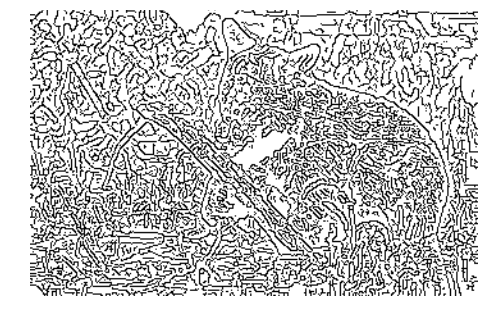

In [8]:
sql = """
        SELECT
            img_name,
            imgsize,
            edges
        FROM
            iot.edges_table
        WHERE img_name like '%Images/CBIR/Caltech256/256_ObjectCategories/009.bear/009_0049.jpg%'
        LIMIT 1;        
"""
df = psql.read_sql(sql,conn)

imgname = np.array(df.loc[0]['img_name'])
size = np.array(df.loc[0]['imgsize'])
edges = np.array(df.loc[0]['edges'])
edges = np.reshape(edges, (size[0],size[1]))
plt.imshow(edges)
plt.axis('off')
plt.show()

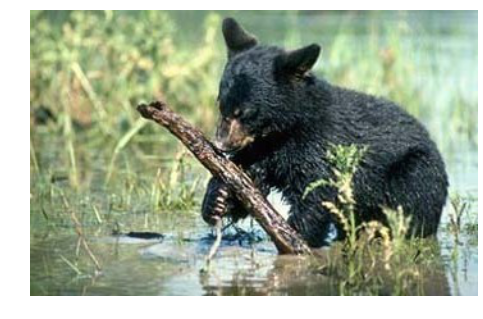

In [9]:
import StringIO
sql = """
        SELECT
            img_name,
            img
        FROM
            iot.src_image
        WHERE img_name like '%Images/CBIR/Caltech256/256_ObjectCategories/009.bear/009_0049.jpg%'
        LIMIT 1;        
"""
df = psql.read_sql(sql,conn)

imgname = np.array(df.loc[0]['img_name'])

img = df.loc[0]['img']
buf = img.split(',')
buf = map(int, buf)
from array import array
buf = array('b',buf)
buf = buf.tostring()

#print buf
buff = StringIO.StringIO() 
buff.write(buf)
buff.seek(0)
im = Image.open(buff)
plt.imshow(im)
plt.axis('off')
plt.show()

In [10]:
conn.close()